In [1]:
# Сегментация и разметка датасета

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from matplotlib.image import imread, imsave

In [3]:
data_path = 'data/boards/cut/'
images_list = os.listdir(data_path)

In [4]:
def apply_mask(img, mask):
    res = img.copy()
    h, w, _ = img.shape
    for i in range(h):
        for j in range(w):
            if mask[i, j] > 0:
                res[i, j] = mask[i, j]
    return res

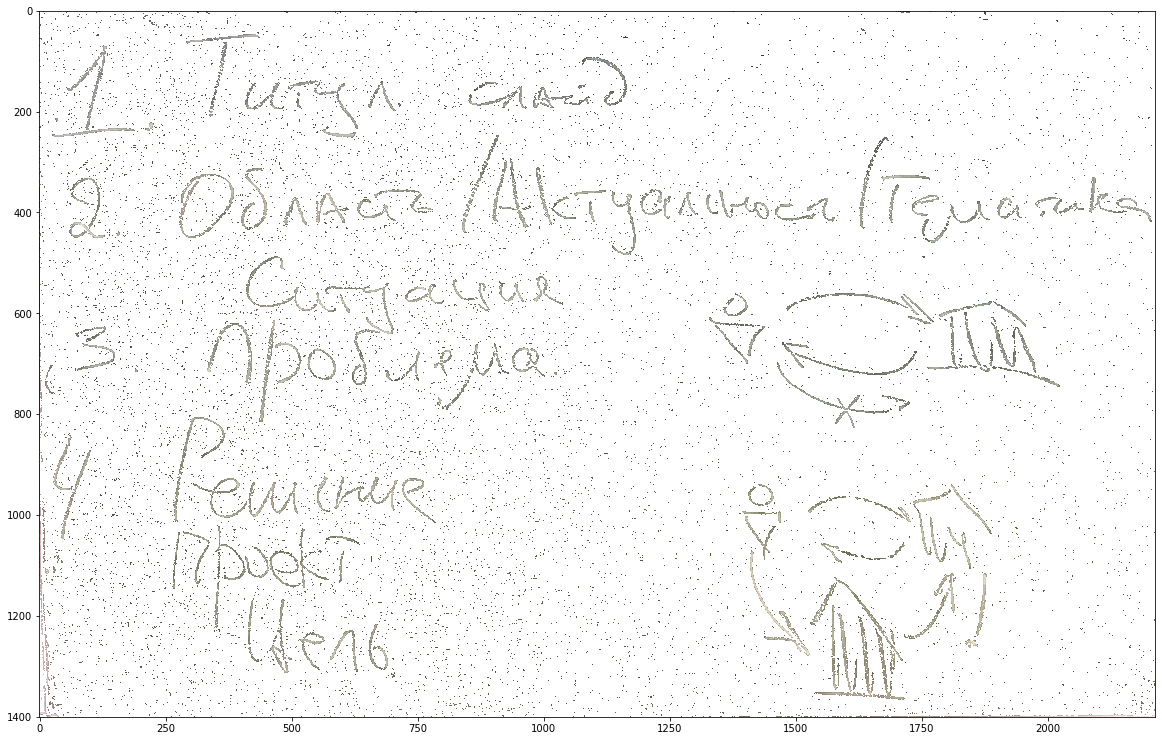

In [5]:
# Пороговая бинаризация
img = cv2.imread('{}{}'.format(data_path, images_list[125]))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = 255 - gray
mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
masked = apply_mask(img, mask)
cv2.imwrite('data/mask.png', mask)
plt.figure(figsize=(20, 20))
plt.imshow(masked)

In [13]:
def EPS_function(width):
    return (width ** (2/3)) / 6

In [14]:
def segmentation(img):
    # TODO: Рассчёт значений EPS и MIN SAMPLES для каждого изображения
    h, w, _ = img.shape
    EPS1 = EPS_function(w)
    print(w, EPS1)
    #EPS2 = w / 40
    #MIN_SAMPLES = w / 100
    
    #print(EPS1, MIN_SAMPLES)
    #print(EPS2)
    
    # Пороговая бинаризация
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
    masked = apply_mask(img, mask)
    plt.figure(figsize=(20, 20))
    plt.imshow(masked)

    # Кластеризация
    X = []
    h, w = mask.shape
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 0:
                X.append([i, j, masked[i, j, 0], masked[i, j, 1], masked[i, j, 2]])
    X = np.array(X)
    
    labels = DBSCAN(eps=EPS1, min_samples=15).fit_predict(X)
    color_list = np.array([(np.random.rand(), np.random.rand(), np.random.rand()) for i in range(max(labels) + 1)])

    # Убрать шум
    Y = []
    new_labels = []
    for k, x in enumerate(X):
        if labels[k] >= 0:
            new_labels.append(labels[k])
            Y.append(x)

    new_labels = np.array(new_labels)   
    Y = np.array(Y)

    plt.figure(figsize=(20, 20))      
    #plt.scatter(Y[:, 1], Y[:, 0], c=color_list[new_labels])
    
    # Выделение сегментов
    segments_d = {}
    for k, l in enumerate(new_labels):
        if l not in segments_d:
            segments_d[l] = []
        segments_d[l].append([Y[k, 0], Y[k, 1]])
    
    # Рассчёт центров
    centroids = []
    for k in segments_d:
        centroids.append(np.sum(segments_d[k], axis=0) // len(segments_d[k]))
    centroids = np.array(centroids)
    #plt.scatter(centroids[:, 1], centroids[:, 0], c='black', marker='x')
    
    # Повторная кластеризация
    labels = DBSCAN(eps=30, min_samples=1).fit_predict(np.array([[x[0] * 3, x[1] / 2] for x in centroids]))
    color_list = np.array([(np.random.rand(), np.random.rand(), np.random.rand()) for i in range(max(labels) + 1)])
    
    #plt.scatter(Y[:, 1], Y[:, 0], c=color_list[labels])
    
    # Сегментация
    new_segments_d = {}
    show = []
    new_labels = []
    for k, x in enumerate(segments_d):
        if k > 0:
            show = np.append(show, segments_d[x], axis=0)
        else:
            show = segments_d[x]
            
        if labels[k] not in new_segments_d:
            new_segments_d[labels[k]] = segments_d[x]
        else:
            new_segments_d[labels[k]] = np.append(new_segments_d[labels[k]], segments_d[x], axis=0)
        
        new_labels = np.append(new_labels, [labels[k] for _ in segments_d[x]])
    
    new_labels = np.array(new_labels, dtype='uint8')
    show = np.array(show)
    color_list = np.array([(np.random.rand(), np.random.rand(), np.random.rand()) for i in range(max(new_labels) + 1)])
    plt.scatter(show[:, 1], show[:, 0], c=color_list[new_labels])
    
    segments = []
    for k in new_segments_d:
        x = np.array(new_segments_d[k])
        off_y, off_x = (min(x[:, 0]), min(x[:, 1]))
        h, w = (max(x[:, 0]) - off_y + 1, max(x[:, 1]) - off_x + 1)
        seg = np.empty((h, w), dtype='uint8')
        seg.fill(255)
        for el in x:
            seg[el[0] - off_y, el[1] - off_x] = 0

        segments.append((seg, ((off_x, off_y), (w + off_x, h + off_y))))
    
    print('Segments: {}'.format(len(segments)))
    
    return np.array(segments)

(1847, 3104, 3)
(1210, 720)
1210 18.92513545003339
Segments: 39
(3096, 4128, 3)
(960, 720)
960 16.219205321529063
Segments: 37
(3096, 4128, 3)
(960, 720)
960 16.219205321529063
Segments: 69
(3096, 4128, 3)
(960, 720)
960 16.219205321529063
Segments: 54
(3096, 4128, 3)
(960, 720)
960 16.219205321529063
Segments: 49
(1373, 2626, 3)
(1280, 669)
1280 19.64816799274872
Segments: 25
(2230, 2212, 3)
(714, 720)
714 13.314173870700415
Segments: 30
(3096, 4128, 3)
(960, 720)
960 16.219205321529063
Segments: 83
(3096, 4128, 3)
(960, 720)
960 16.219205321529063
Segments: 59
(3096, 4128, 3)
(960, 720)
960 16.219205321529063
Segments: 49


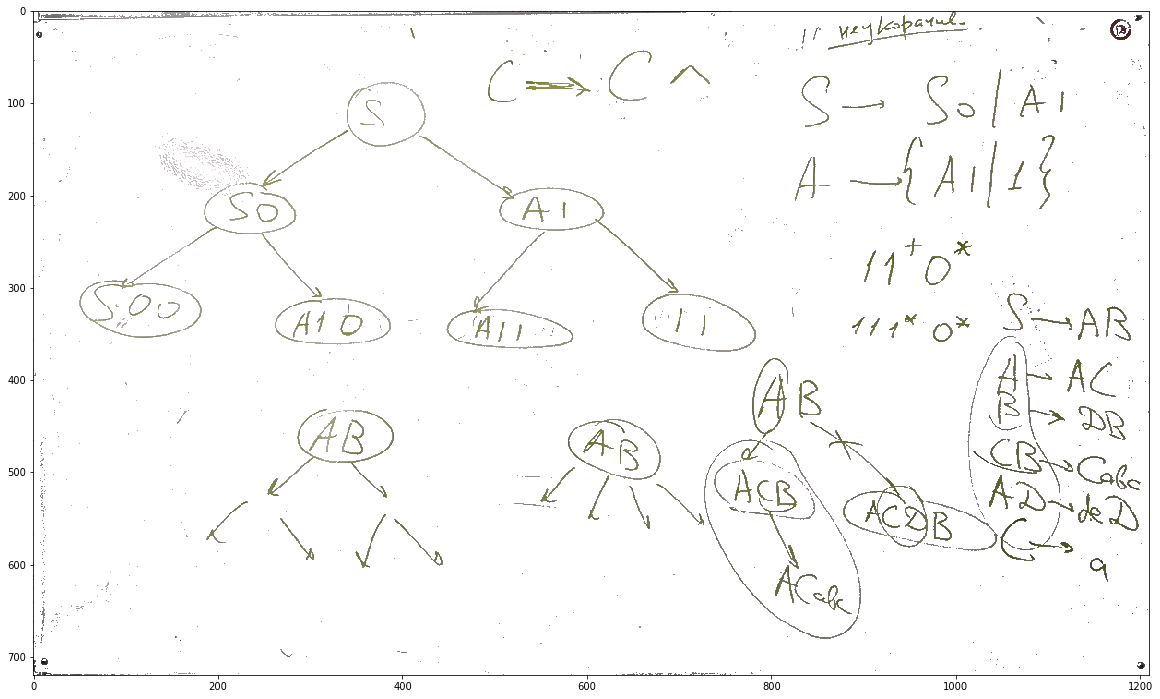

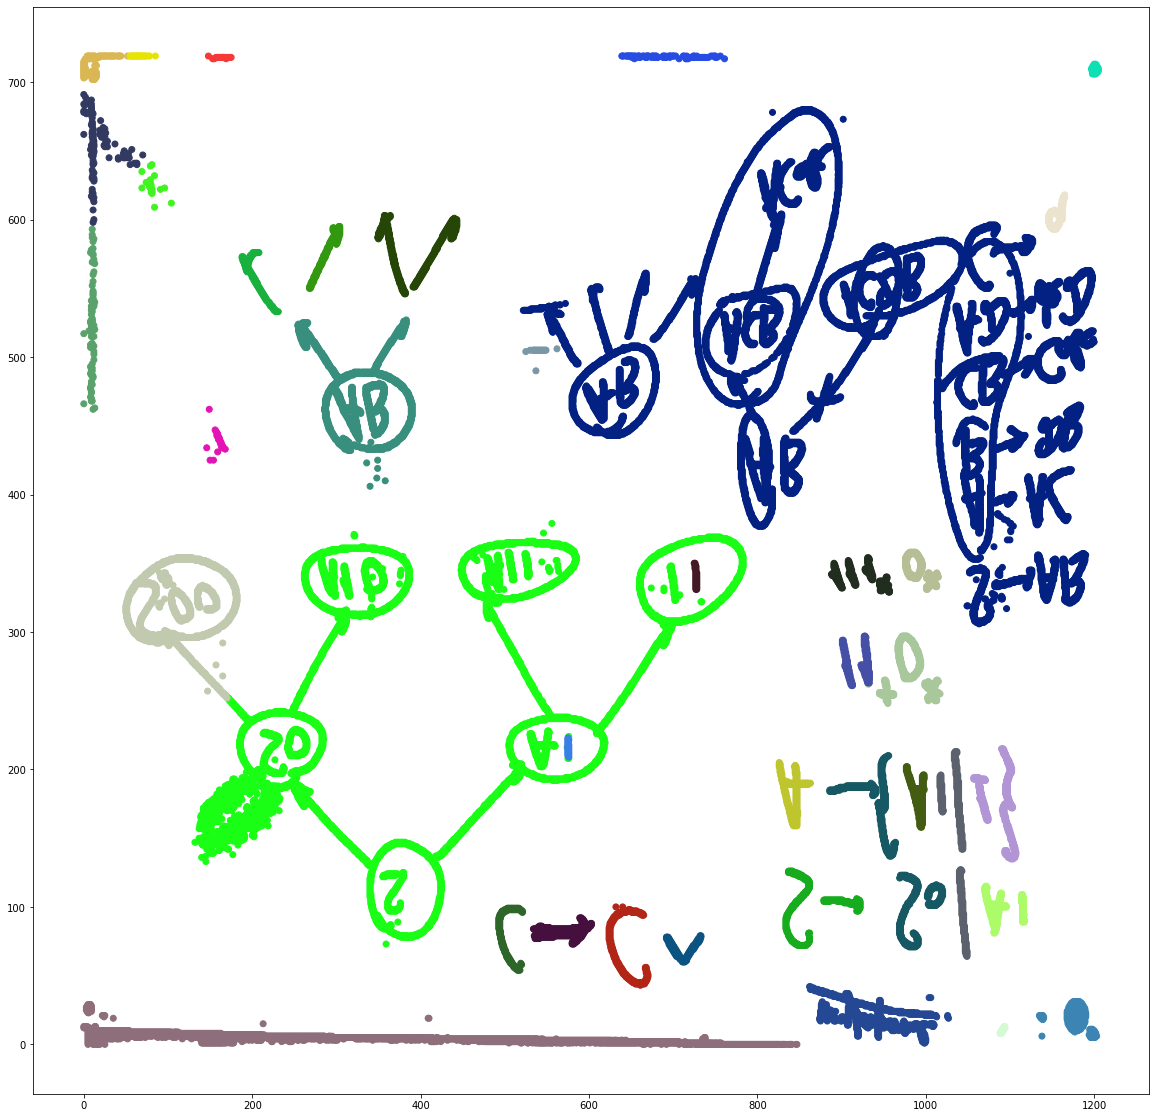

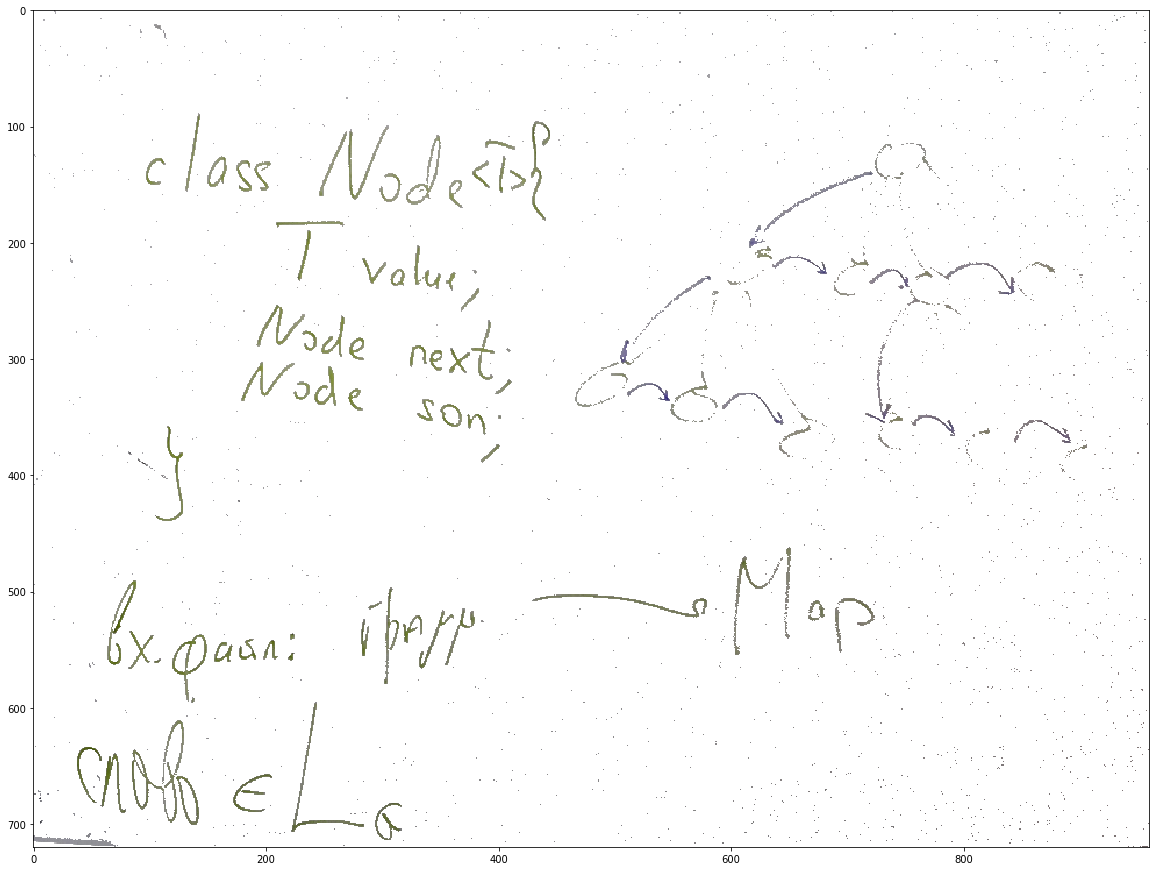

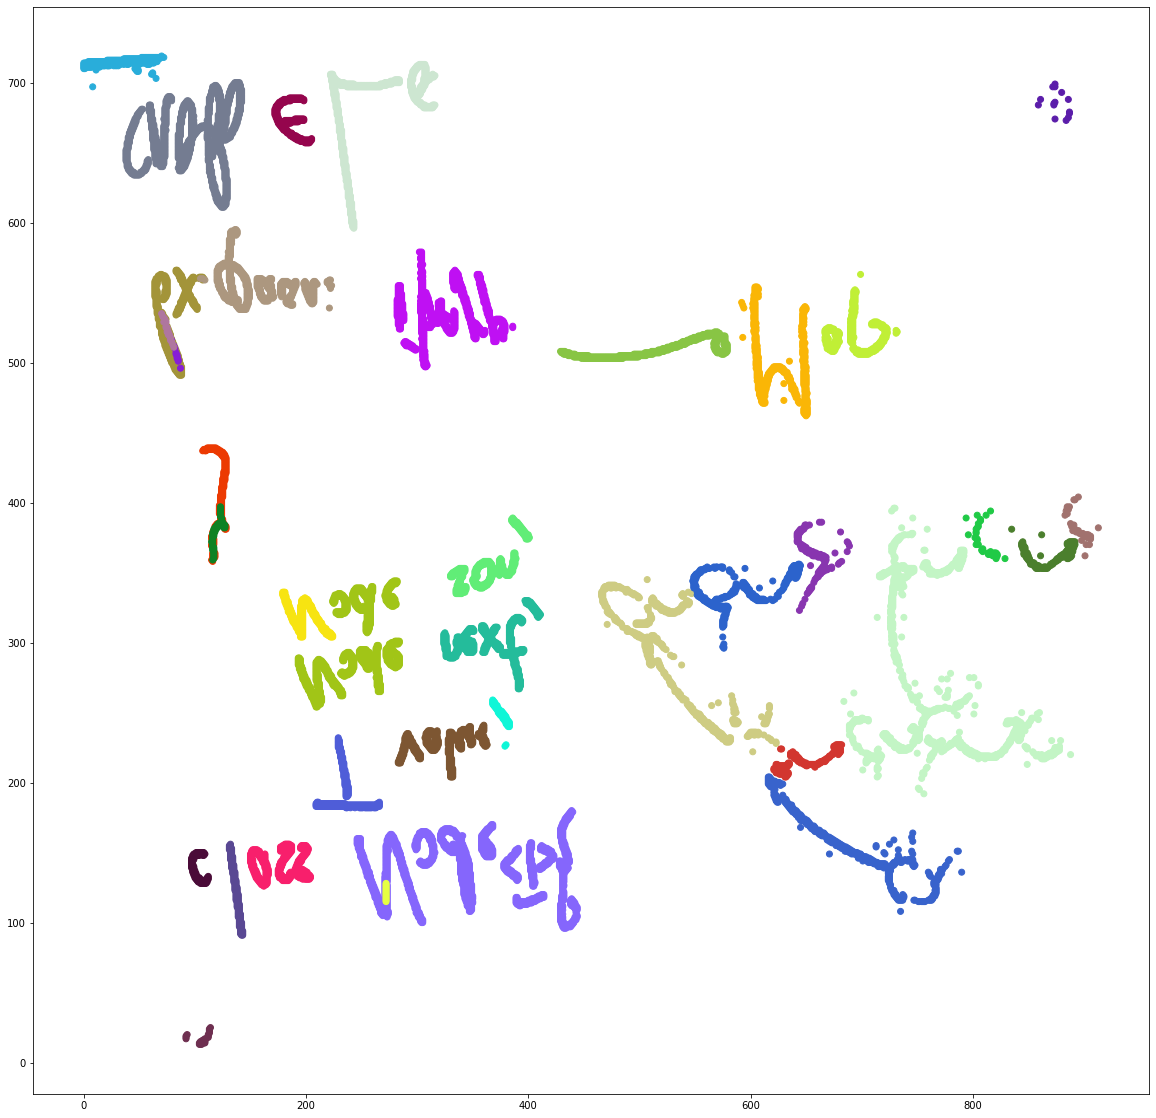

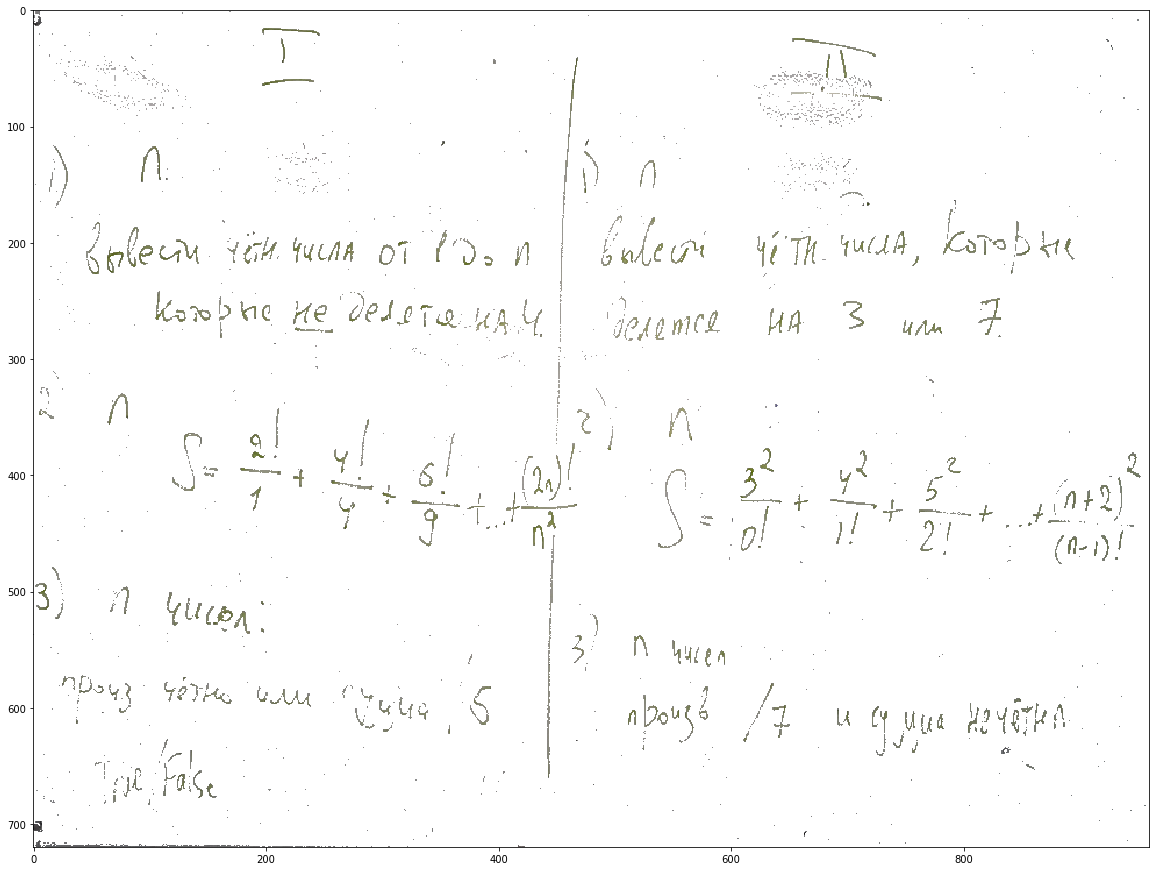

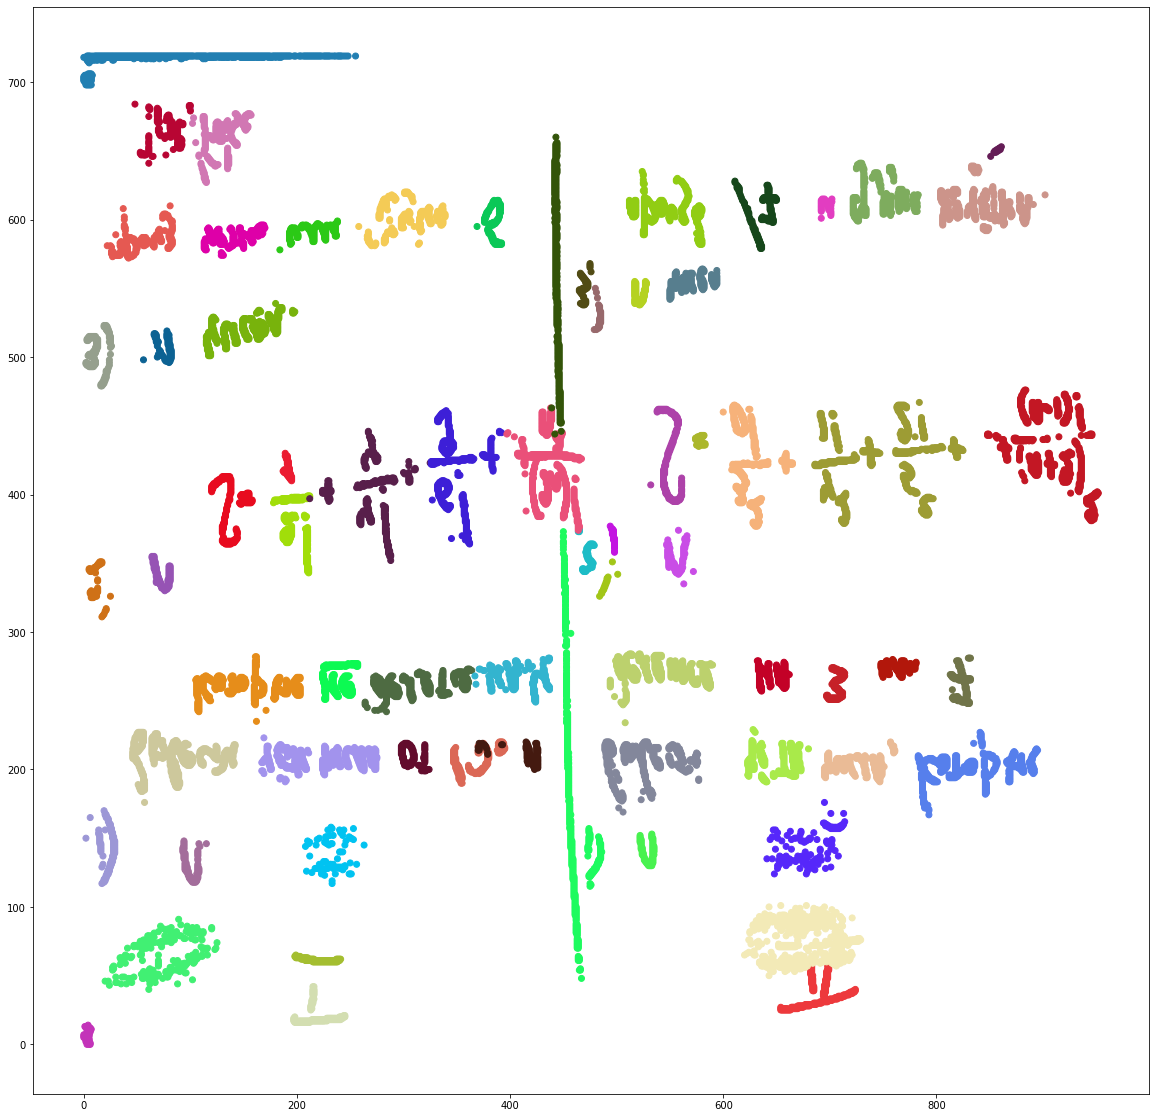

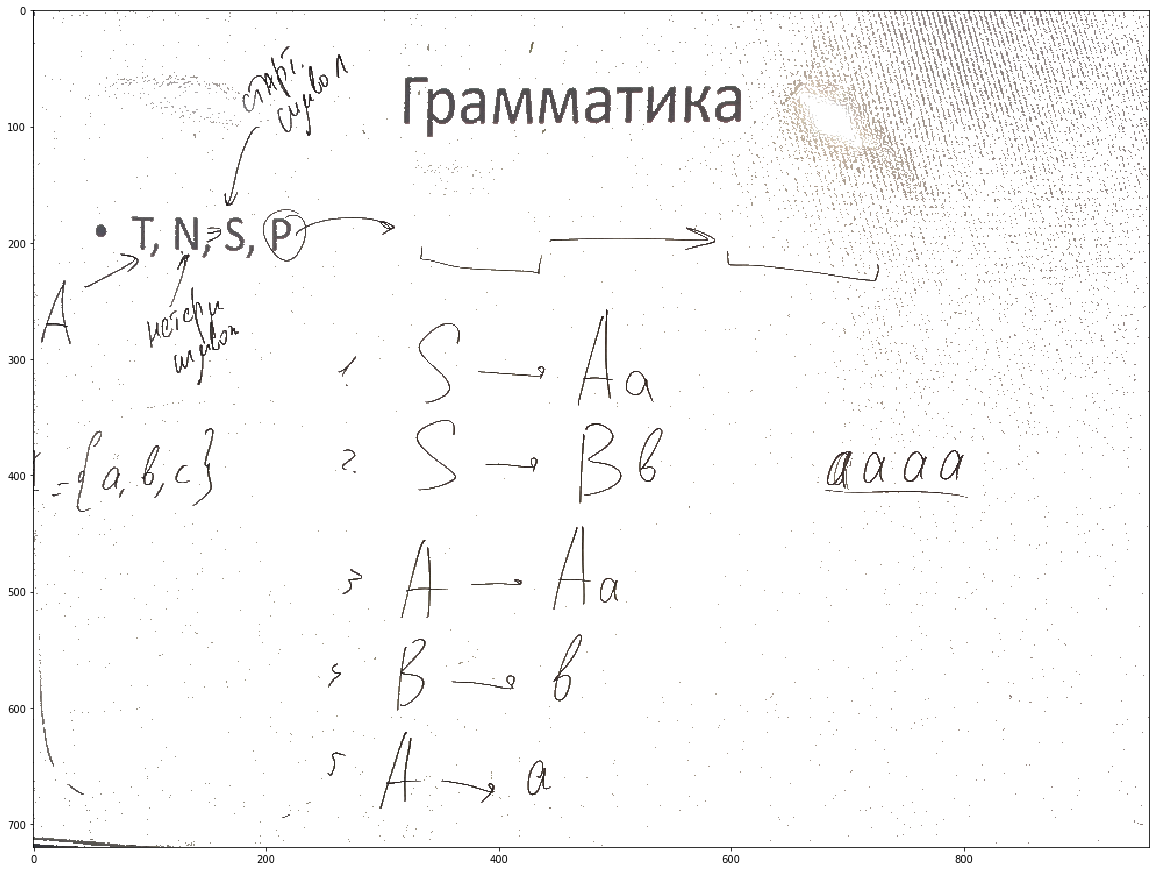

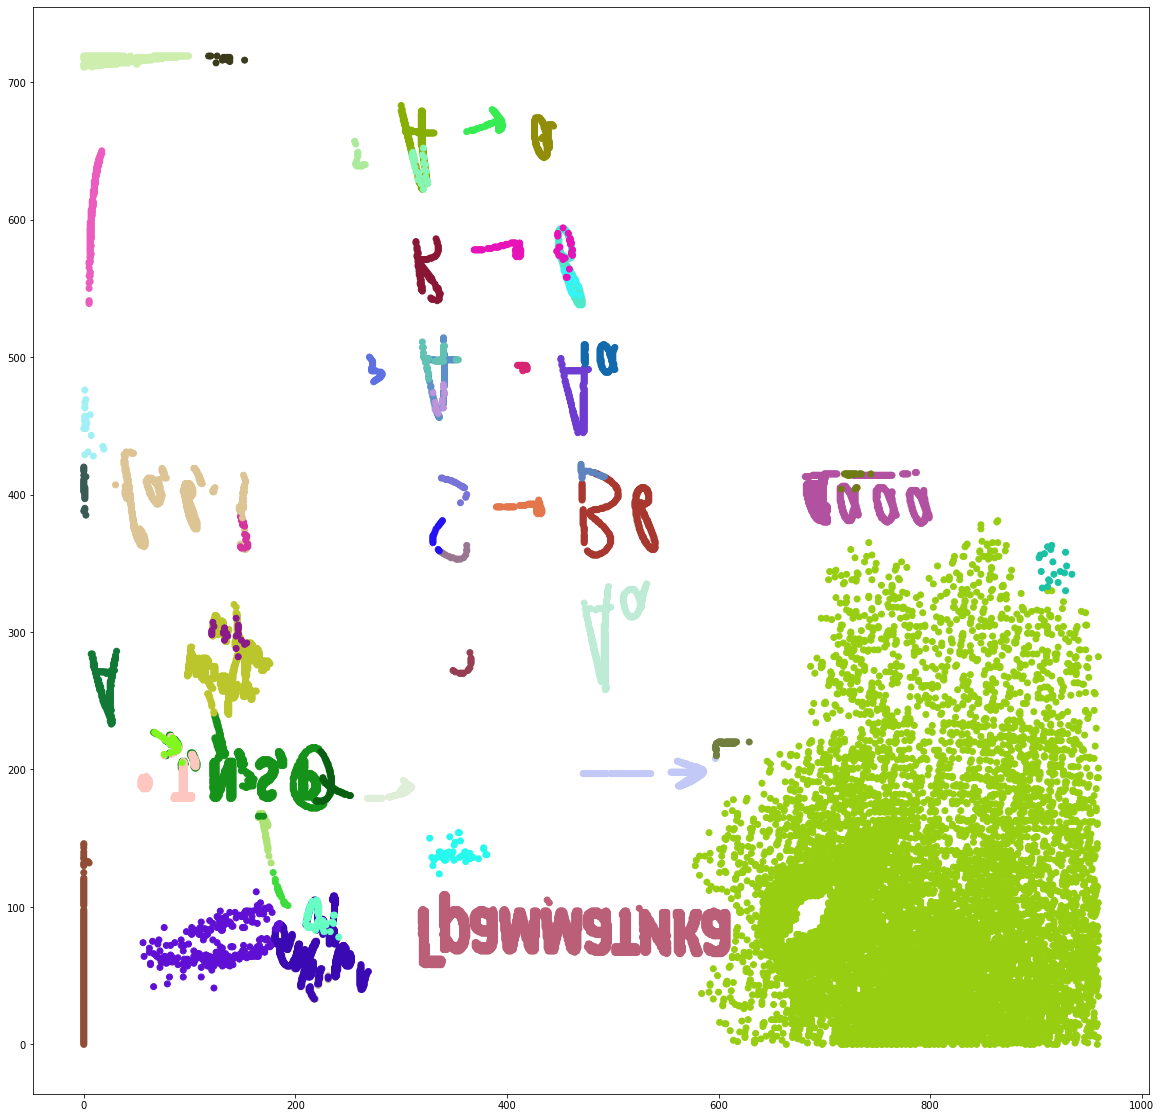

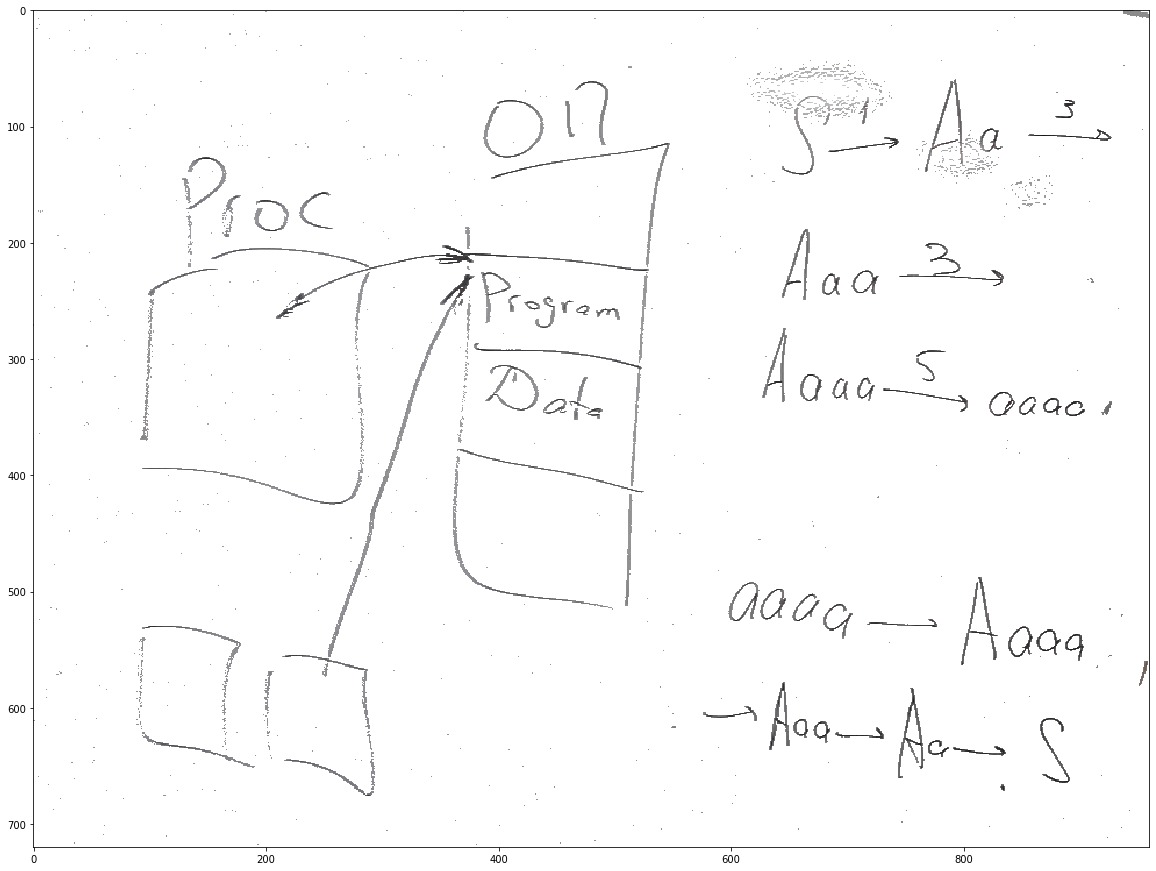

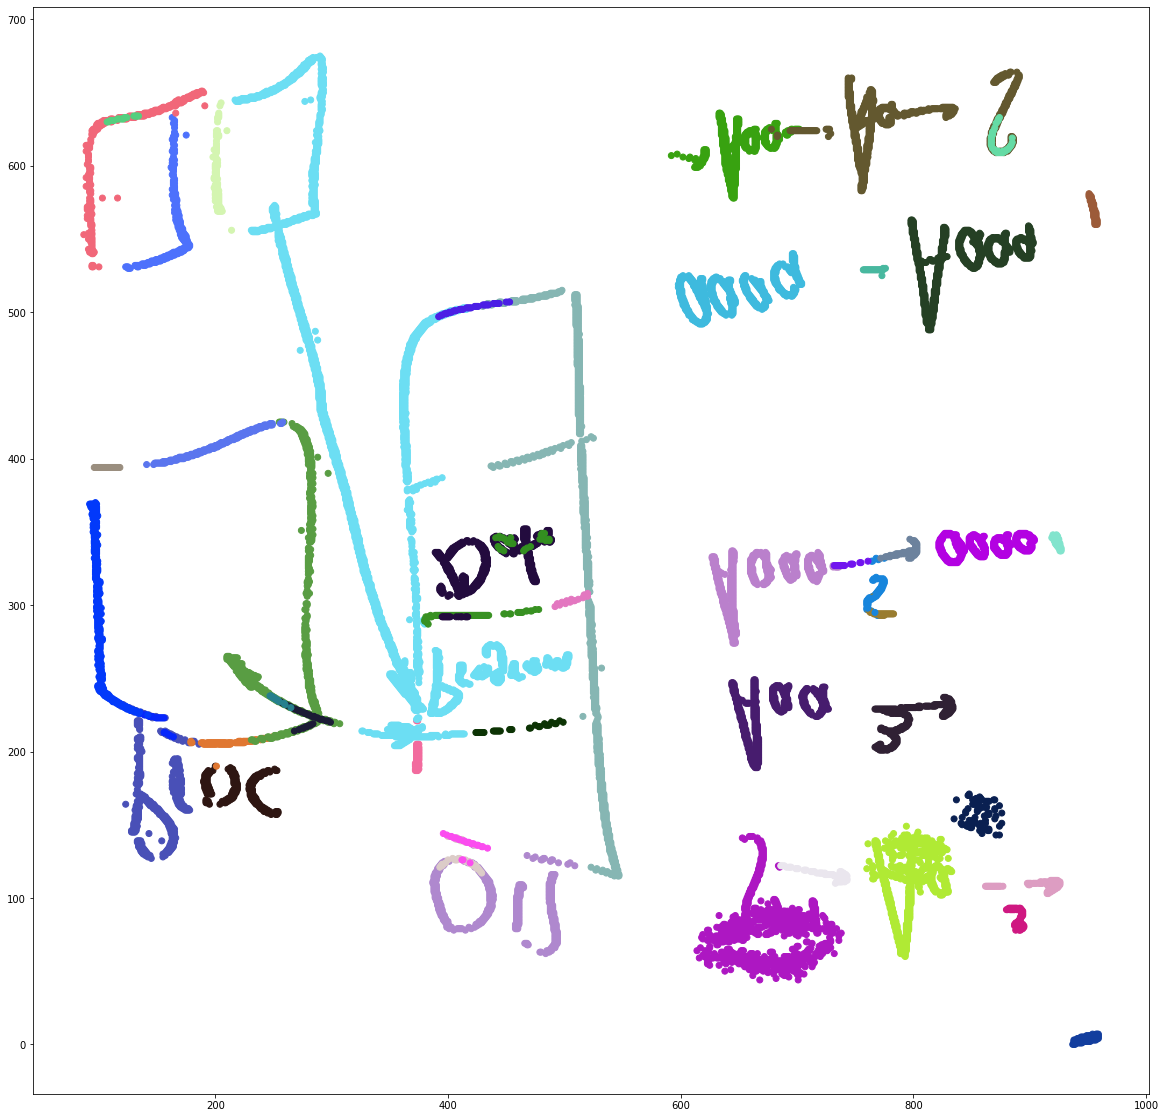

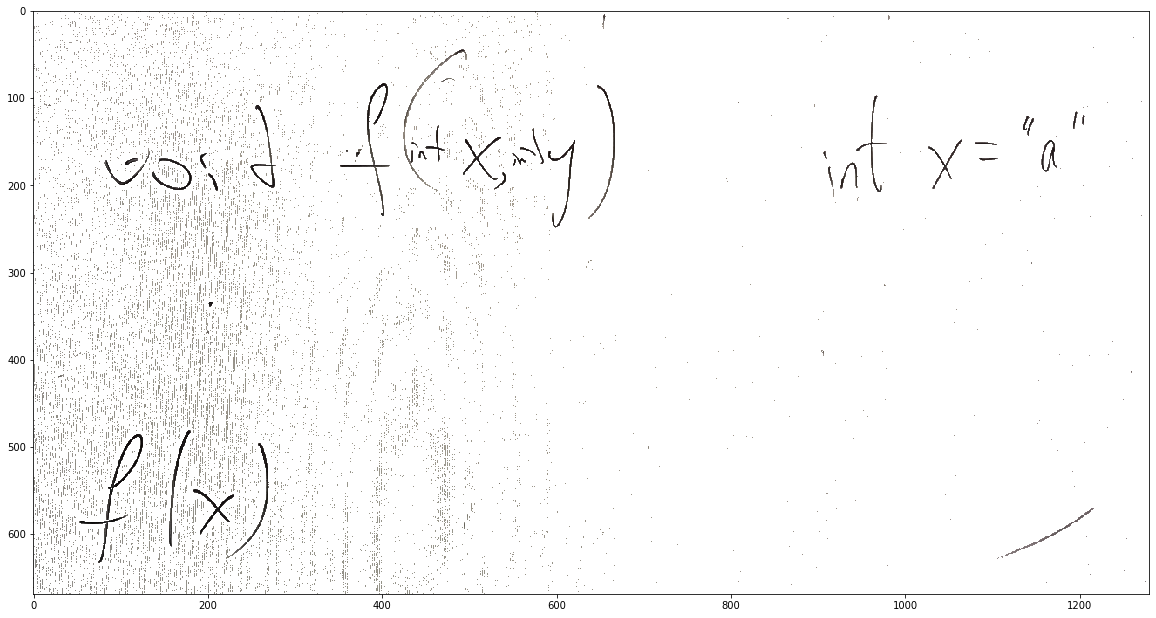

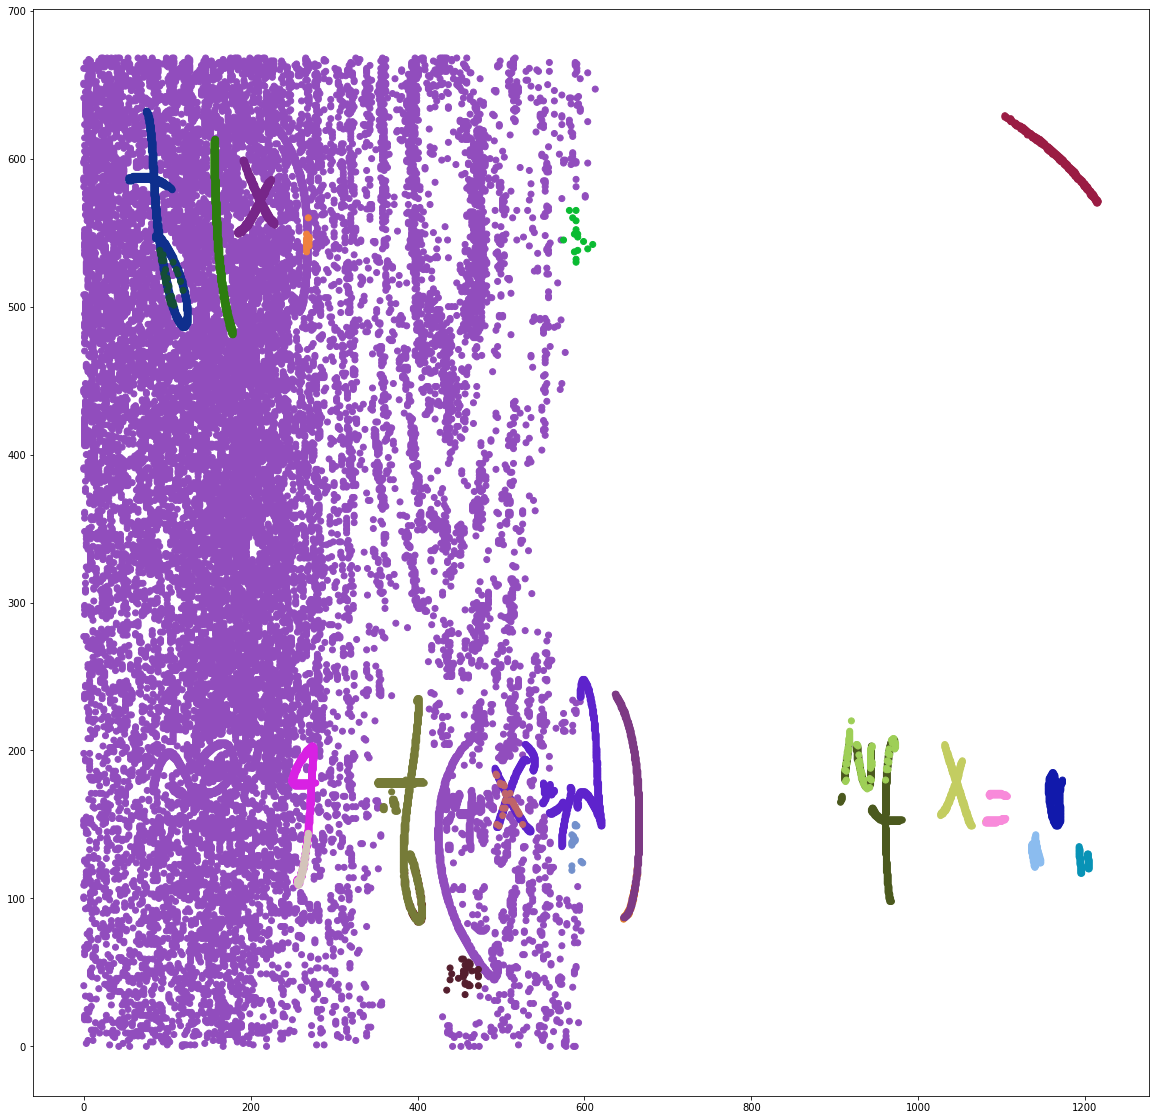

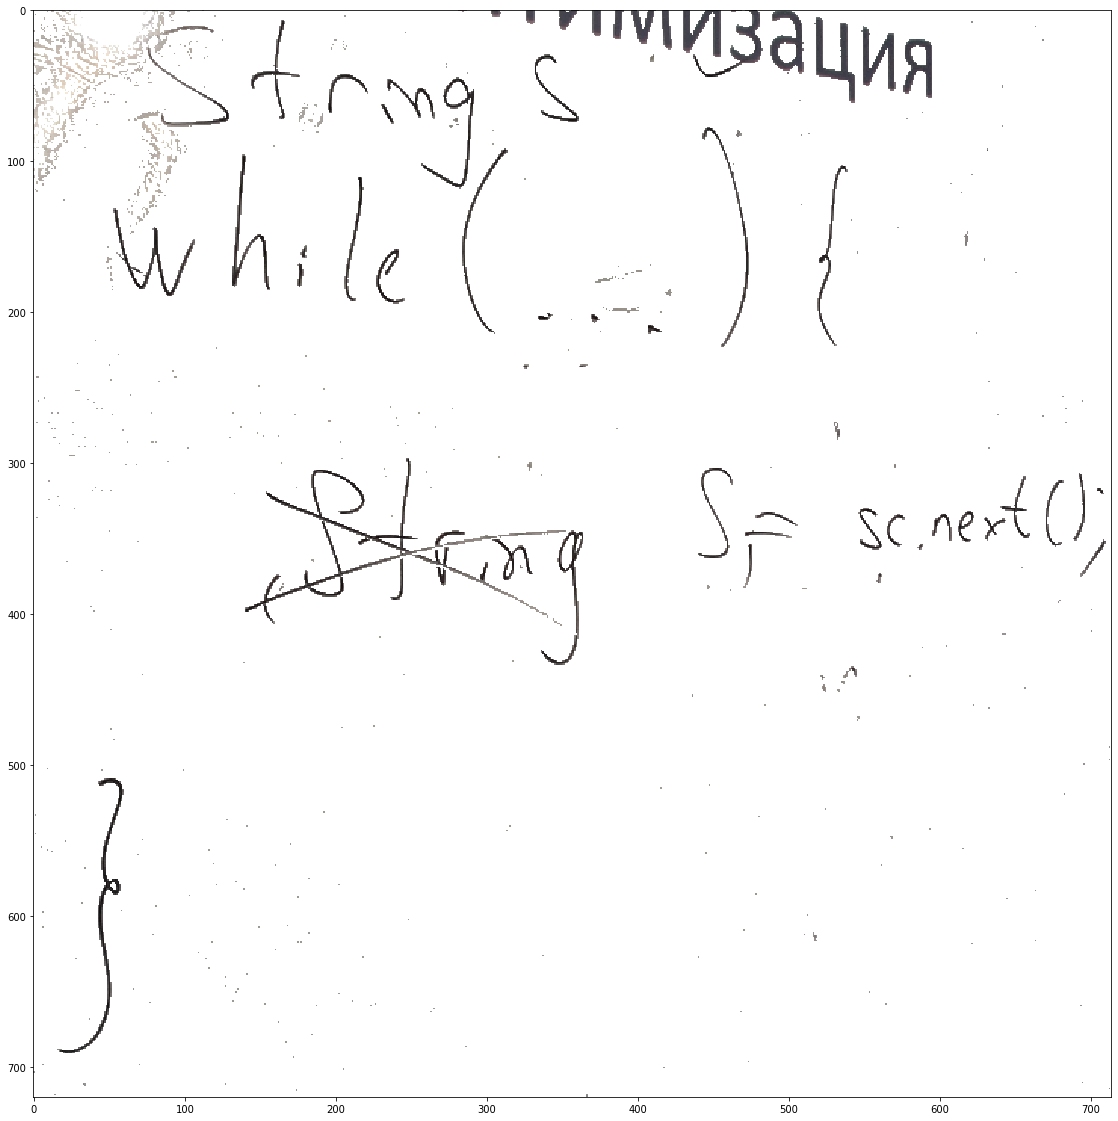

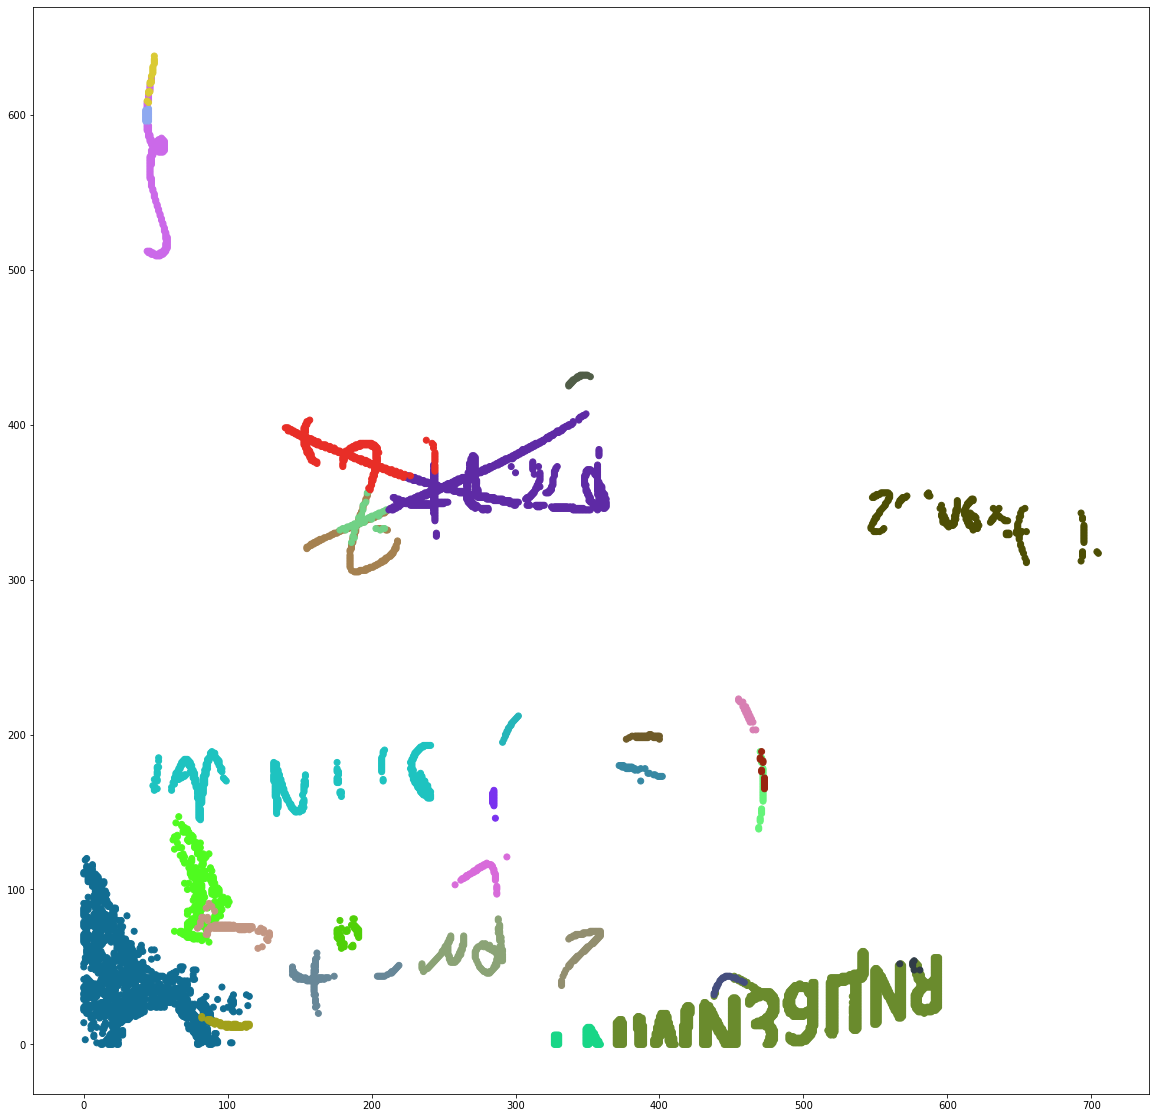

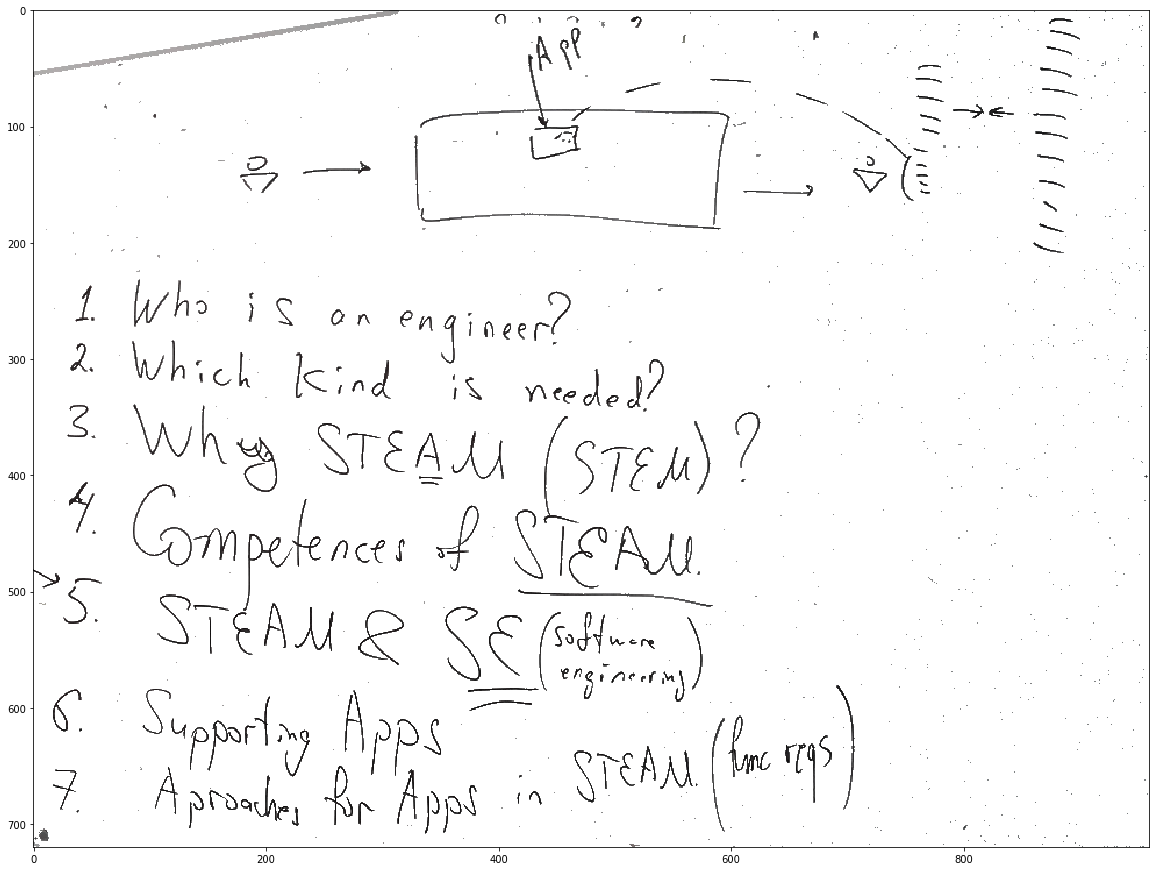

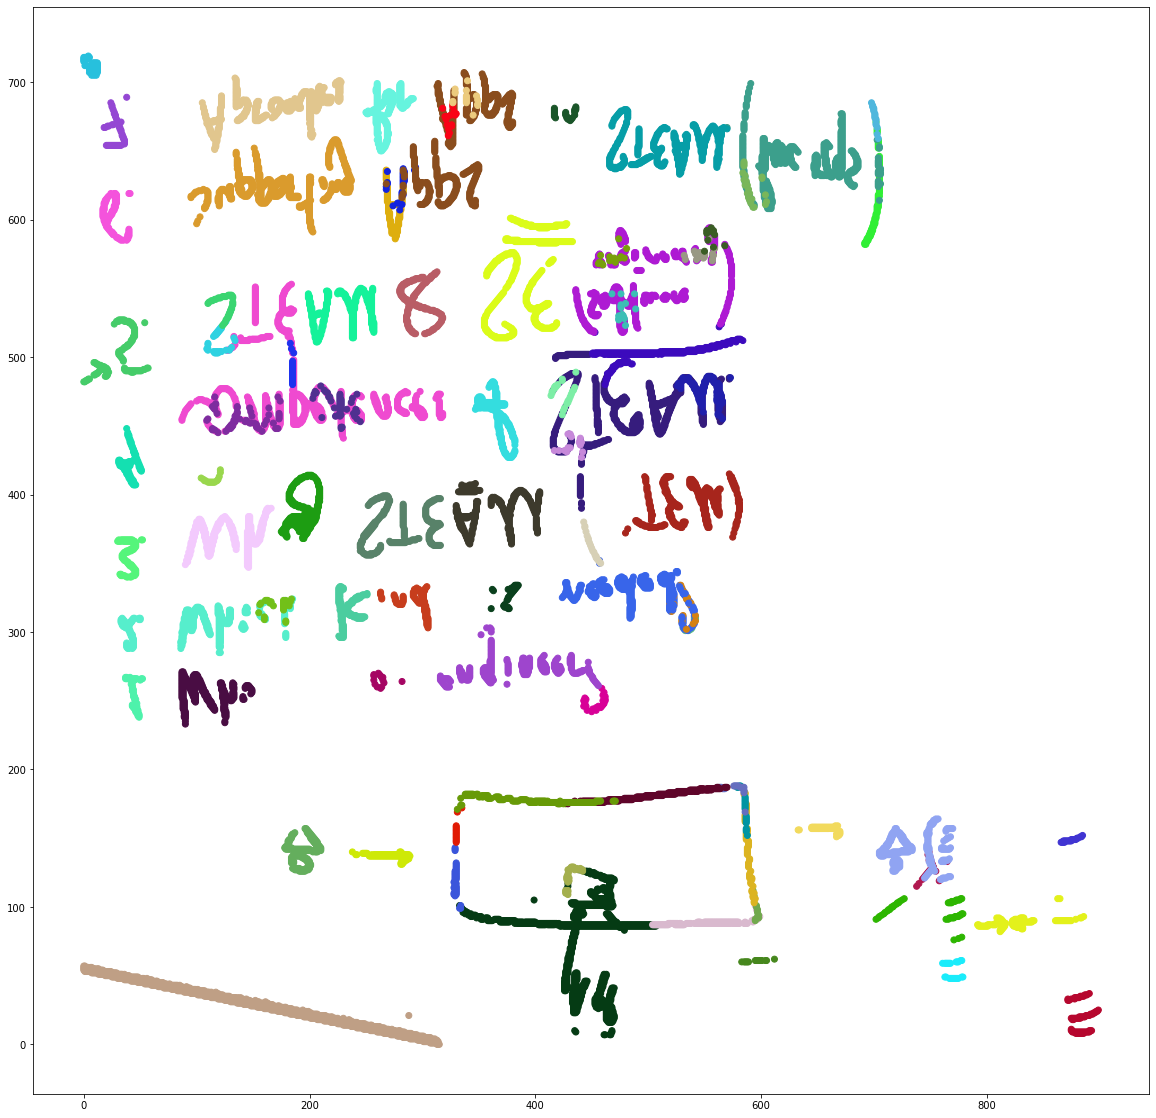

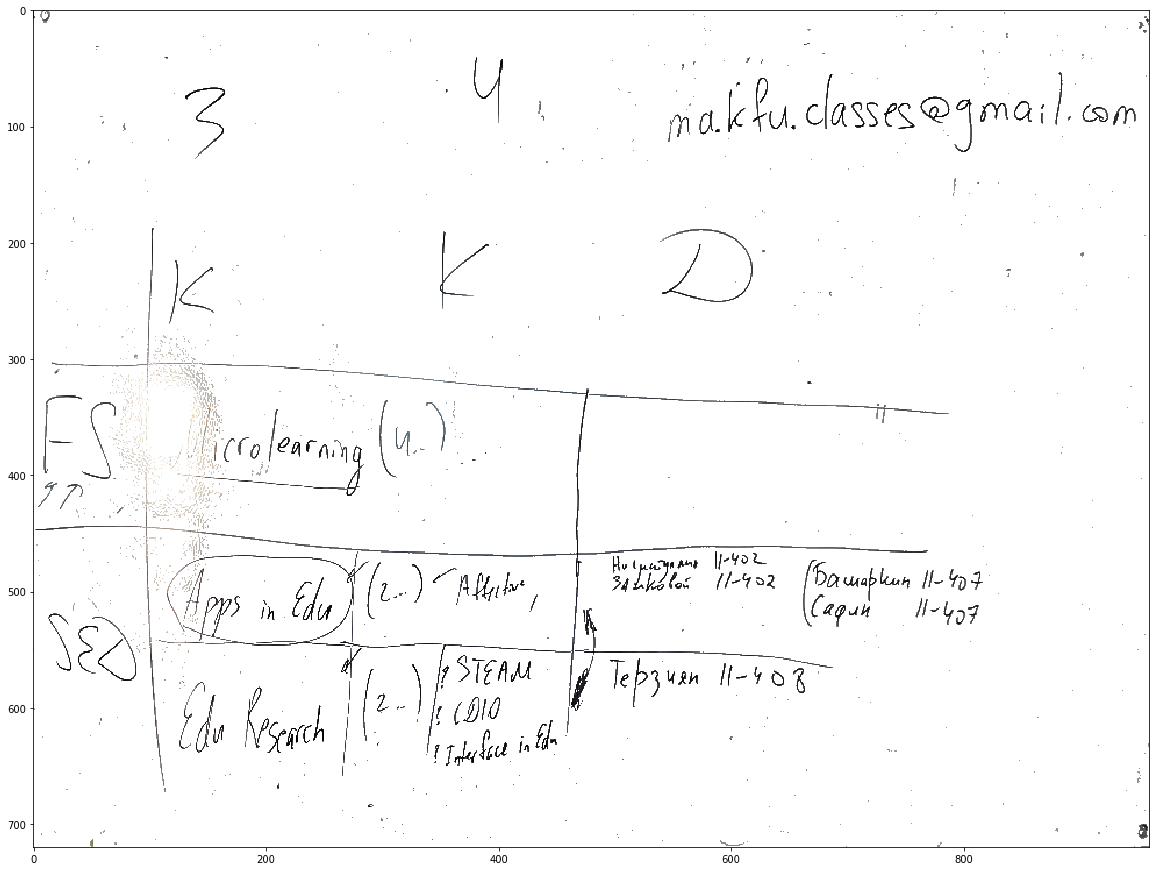

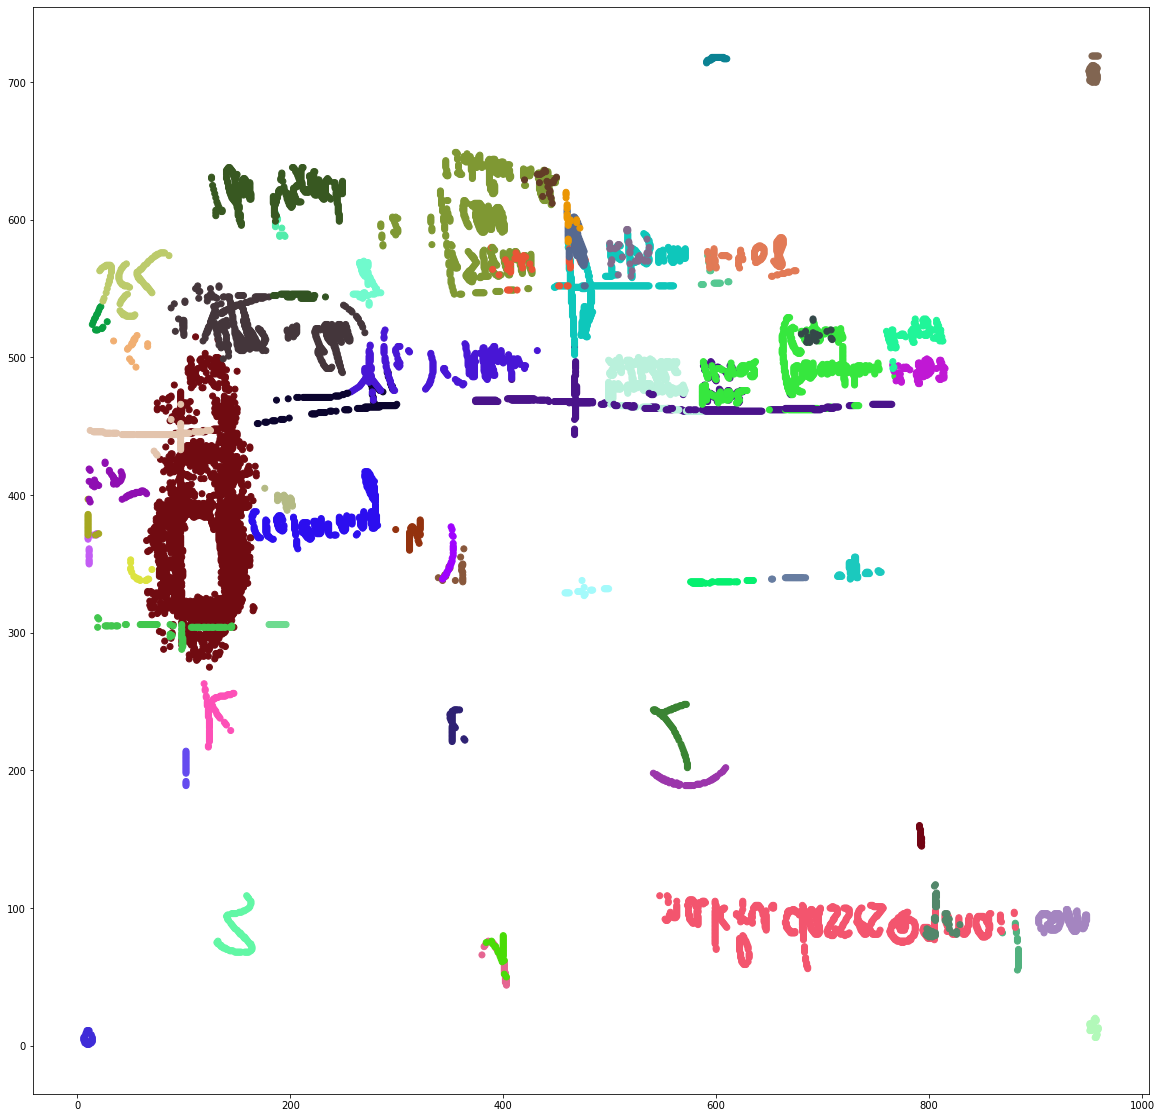

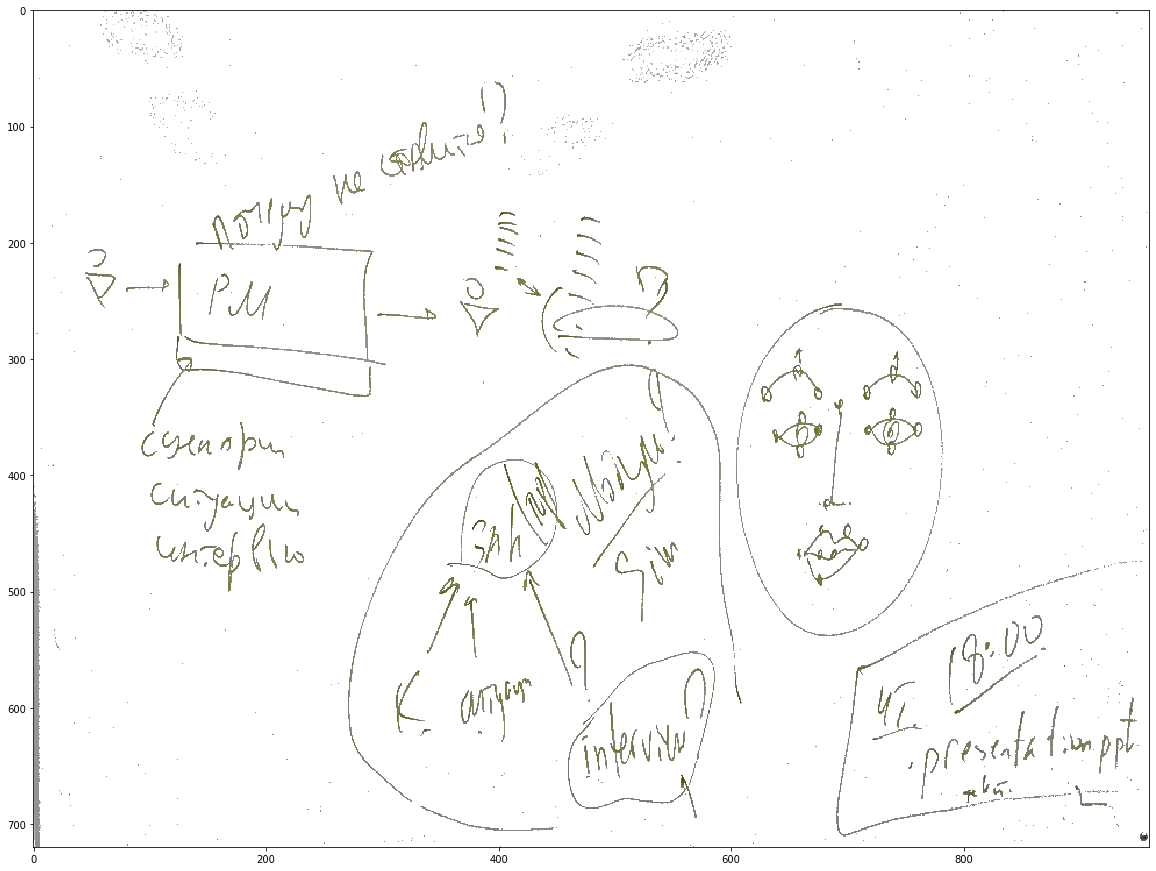

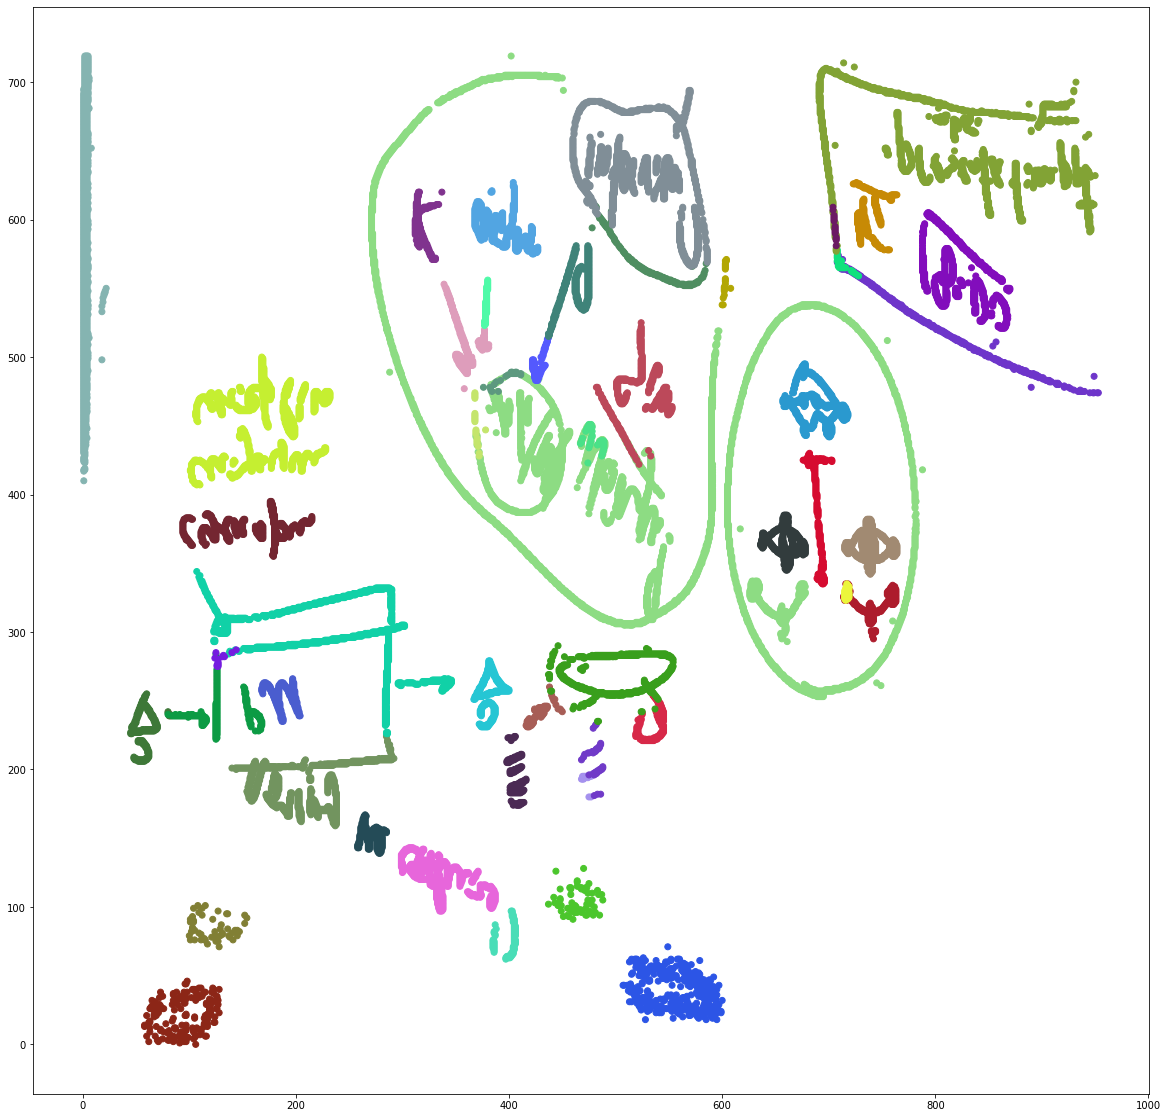

In [15]:
# Тестовая сегментация
seg_path = 'data/boards/seg/'

for x in images_list[:10]:
    img = cv2.imread('{}{}'.format(data_path, x))
    
    print(img.shape)

    # Пропорциональное сжатие/растяжение
    wt, ht = 1280, 720
    h, w, _ = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    print(newSize)

    #seg = segmentation(img)
    seg = segmentation(cv2.resize(img, newSize))
#for k, s in enumerate(seg):
    #img = cv2.rectangle(img, s[1][0], s[1][1], (0, 255, 0), 3)
    
#plt.imshow(img)
    #cv2.imwrite('{}{}.png'.format(data_path, k), s)
    #cv2.imshow('x', s)
    #cv2.waitKey()
    #cv2.destroyAllWindows()